# **MOD510: Project4**

What can we learn about a system if we inject a tracer and measure the outlet concentration as a function of time?

**MOD510: Project 4**

Date: **December 1st 2025**

Names: **Malvin Varpe & Torgrim Odde**

## **Introduction**  
Mixing tanks are fundamental components in chemical and environmental engineering. They are often used to model processes such as chemical reactions, heat
transfer, and pollutant dispersion. In this exercise, we will model a system of
interconnected mixing tanks using a stochastic modeling approach based on
Monte Carlo methods. Beginning with a single tank, you will progressively
model a three-tank system, incorporating uncertainty estimation and validating
results against ordinary differential equation (ODE) solutions.



## Exercise 1: Stochastic modeling of mixing tanks  

## Exercise 2: Spreading of contaminants in underground aquifers using random walk  
### Part 1. 2D Random Walk Model  
**1. Basic Model:**   
*Initialize 1000 particles positioned on a square grid centered at (1000, 1000)(Figure 2).*    
• *At each time step, move (or don’t move) each particle one integer step in the x and y directions. No diagonal walking should be allowed.*    
• *Ensure that if a particle’s movement takes it beyond the predefined boundary of the space (0 ≤ x ≤ 2000, 0 ≤ y ≤ 2000; Figure 2), the simulation stops.*  
***Solution 1.1:***

Number of steps taken: 186172. Average time per step per walker: 0.036496 microseconds.


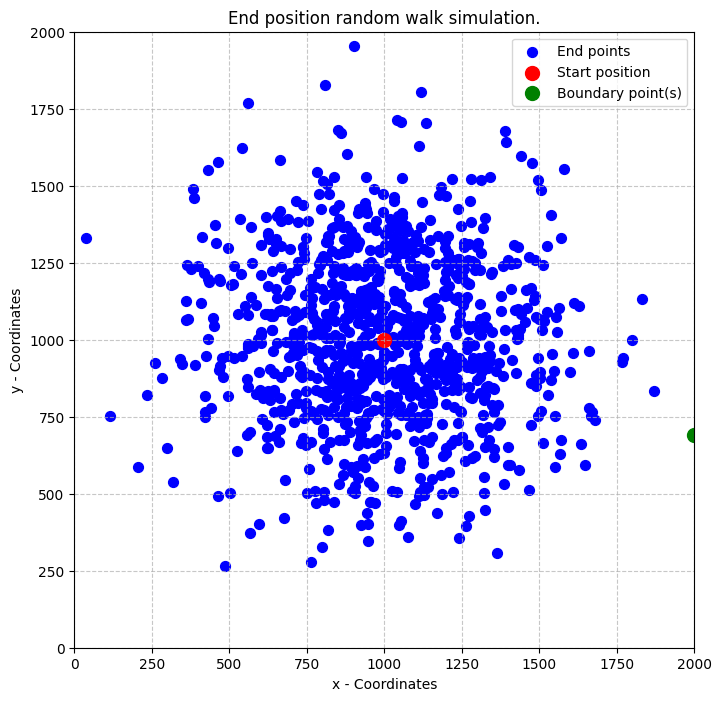

In [20]:
import time 
import numpy as np
import matplotlib.pyplot as plt

#Initialize 1000 particles at (1000,1000)
def start_pos_f(n = 1_000, start_pos=(1_000,1_000)):
    start_pos = np.array(start_pos)
    pos = np.ones((n, 2)) * start_pos
    return pos

def one_step(arr):
    directions = np.random.randint(0, 5, size=len(arr))

    # At each step move or dont move. Only moves along one of the axis.
    dx = np.array([0, 1, -1, 0, 0])
    dy = np.array([0, 0, 0, 1, -1])
    arr += np.stack([dx[directions], dy[directions]], axis=1)
    return arr

def rndm_walk_plain(n_steps, n_walkers=1_000, lower_bound=0, higher_bound=2_000):
    k=0
    pos = start_pos_f(n_walkers)
    t0 = time.perf_counter()
    
    for _ in range(n_steps):
        
        pos = one_step(pos)
        k+=1 
        # Ensure that the particle's movement doesn't exceed boundaries.
        if np.any(pos <= lower_bound) or np.any(pos >= higher_bound):
            break
    t1 = time.perf_counter()
    t = t1-t0
        
    return pos, k, t

def plot_positions_matplotlib(
        array, 
        title, 
        xlim=(0, 2000), 
        ylim=(0, 2000), 
        start_pos=(1000, 1000), 
        boundary=True,
        x_label="x - Coordinates", 
        y_label = "y - Coordinates",
        
        ):
    
    if boundary:
        boundary_points_x = xlim
        boundary_points_y = ylim
        mask_boundary = (
            (array[:, 0] <= boundary_points_x[0]) | (array[:, 0] >= boundary_points_x[1]) |
            (array[:, 1] <= boundary_points_y[0]) | (array[:, 1] >= boundary_points_y[1])
        )

        boundary_points = array[mask_boundary]
    else:
        boundary_points = np.empty((0, array.shape[1]))


    plt.figure(figsize=(8, 8))
    plt.scatter(array[:,0], array[:,1], color='blue', s=50, label = 'End points')  # s = dot size
    plt.scatter(start_pos[0], start_pos[1], color='red', s=100, label='Start position')  # Start position in red
    if not boundary_points.size == 0: 
        plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='green', s=100, label='Boundary point(s)')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

n_walkers=1000
pos, k_plain, t = rndm_walk_plain(n_steps=1_000_000, n_walkers=n_walkers, lower_bound=0, higher_bound=2000)
avg_per_plain = t/(n_walkers * k_plain)
print(f"Number of steps taken: {k_plain}. Average time per step per walker: {avg_per_plain*1e6:.6f} microseconds.")
plot_positions_matplotlib(pos,title=f"End position random walk simulation.")

Stopping the iterations when reaching the boundaries, and plotting the end points of all the runs. By running the code multiple times we can see that the number of runs needed to hit the boundary often is between 150000 and 200000 steps. We are also noting that the code takes some time to run, only with 200000 iterations. 
***
**2. Probability-Weighted Movement:**  
*Modify the program to define different probabilities for a particle moving (or not) in the x and y directions. In 2D, there should be a total of nine possible movement directions, including staying in place. Each movement is associated with a defined probability.* 
• *Verify that the sum of all movement probabilities equals 1.*  
  
***Solution 1.2:*** Assuming that we now can move diagonally (Because we now have nine movements). 

Number of steps taken: 102478. Average time per step per walker: 0.053516 microseconds.


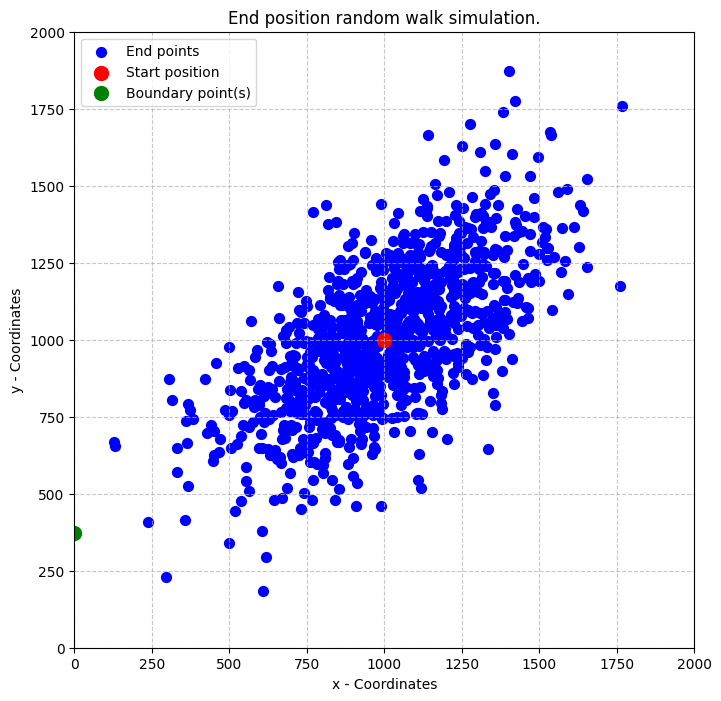

In [14]:
def one_step_mod(
        arr,
        p_ss=1/9, #0
        p_ps=1/9, #1
        p_sp=1/9, #2
        p_pp=1/9, #3
        p_ns=1/9, #4
        p_sn=1/9, #5
        p_nn=1/9, #6
        p_np=1/9, #7
        p_pn=1/9  #8
                 ):
        # Don't check probabilities each time step for improved computation.
        p = [p_ss, p_ps, p_sp, p_pp, p_ns, p_sn, p_nn, p_np, p_pn]


        directions = np.random.choice(9, size=len(arr), p=p)
        dx = np.array([0, 1, 0, 1, -1, 0, -1, -1, 1])
        dy = np.array([0, 0, 1, 1, 0, -1, -1, 1, -1])
        arr += np.stack([dx[directions], dy[directions]], axis=1)
        return arr


def rndm_walk_mod(n_steps, n_walkers=1_000, lower_bound=0, higher_bound=2_000, start_pos=(1_000,1_000),
        p_ss=1/9, #0
        p_ps=1/9, #1
        p_sp=1/9, #2
        p_pp=1/9, #3
        p_ns=1/9, #4
        p_sn=1/9, #5
        p_nn=1/9, #6
        p_np=1/9, #7
        p_pn=1/9  #8
                  ):
    p = [p_ss, p_ps, p_sp, p_pp, p_ns, p_sn, p_nn, p_np, p_pn]
    
    # Check if the sum is equal to 1, with a little round off error.
    if not np.isclose(sum(p), 1.0, atol=1e-8):
        raise ValueError(f"Probabilities must sum to 1. Current sum: {sum(p)}")

    k=0
    pos = start_pos_f(n_walkers, start_pos)
    t0 = time.perf_counter()
    for _ in range(n_steps):
        pos = one_step_mod(pos, *p)
        k+=1 
        if np.any(pos <= lower_bound) or np.any(pos >= higher_bound):
            break
    t1 = time.perf_counter()
    t = t1-t0
    return pos, k, t

pos_mod, k_mod, t_mod = rndm_walk_mod(n_steps=1_000_000, n_walkers=1_000, lower_bound=0, higher_bound=2000, p_pp=2/9,p_pn=0, p_nn=2/9 ,p_np=0)
avg_per_mod = t_mod/(1_000 * k_mod)
print(f"Number of steps taken: {k_mod}. Average time per step per walker: {avg_per_mod*1e6:.6f} microseconds.")
plot_positions_matplotlib(pos_mod,title=f"End position random walk simulation.")

Modifying the probabilities and ending the iterations when reaching the boundary. We can see that despite decreasing the number of iterations used, we still see a higher number for the average time per step per walker. This might be because

### Part 2. 2D Random Walk Model of Contaminant Transportin Aquifers  
**Description:** *Simulate the spread of contaminants in an aquifer using a random walk model and assess contamination risk at varying distances from the source.*   
1. **Define Contaminant Source:** *The contaminant source is located at the central grid point:* 
$$
x = 1000, y = 1000
$$  
*(See Figure 2). Each grid unit represents 10 meters.*    
***Solution 2.1:***

In [93]:
start_point = (1000,1000)

***
2. **Worst-Case Scenario** *A worst-case scenario is defined as the contaminant moving in a straight line toward the targetdistance without any random deviation, at the maximum possible average migration rate of 10 m/year. Calculate the minimum time required for the contaminant to reach a distance of 10 km from the source under this assumption.*  
  
***Solution 2.2:***

We have distance moved per year, and the distance. We can then calculate the minimum time, if the contaminant is moving in a straight line towards the target.  
$$
t = \frac sv=\frac{10000m}{10m/year}=1000years 
$$  

***
  
3. **Simulate Contaminant Spread:** *Implement a 2D random walk where each step moves the contaminant by one grid unit in one of four directions (North, South, East, West) with equal  probability. Simulate the spatial distribution after a fixed number of steps and visualize the concentration map.*  
  

4. **Time to Reach 10 km (Unbiased Random Walk):** *Assume the contaminant moves randomly at an average of 10 m/year.*  
* *Run at least 10 independent simulations and record the time (in years) when the contaminant first reaches a distance of 10 km from the source.*  
* *Plot a histogram of these arrival times.*
* *Determine whether the arrival times approximate a normal distribution.*  
  

5. **Introduce Net Transport (Biased Random Walk):** *Modify the movement probabilities so that the probability of moving South is twice the probability of moving North, while East and West remain equal. Then:*  
* *Simulate 100 runs and plot a histogram of arrival times for reaching 10 km South.*
* *Determine whether the arrival times approximate a normal distribution.*
* *Compare contamination risk for unbiased vs biased cases by computing the ratio of their most likely arrival times for reaching 10 km South.*  
  
***Solution 2.3:***  
We use the grid as a map, and call positive x-direction for east, negative x-direction for west, postitive y-direction for north and negative y-direction for south.

 We also see that the code could use some optimalization by using a more vectorized approach. The difference between these parts and the first part is that we are going to 
 We therefore implement a chunk size that we create the numpy random generated numbers from (instead of many times in the for loop), and then run over number of runners instead. 

In [15]:
import numpy as np
start_point = (1000,1000)
def simulate_path_vec(
        start_point=start_point, 
        p=[0.2, 0.2, 0.2, 0.2, 0.2], 
        n_steps=10000, 
        distance_boundary=True,
        boundary=1000, #Not used if distance_boundary=False
        fixed_boundary=False,
        lower_bound=(0,0), #Not used if fixed_boundary=False
        upper_bound=(2000,2000), #Not used if fixed_boundary=False
        trajectory=False, 
        multiply_factor=1, 
        continue_from_last=False, 
        main_start=(0,0), #Not used if continue from last

        ):
    # Validate probabilities
    if len(p) != 5 or not np.isclose(sum(p), 1.0):
        raise ValueError("Probabilities must be 5 values summing to 1.")
    
    
    directions = np.random.choice(5, size=n_steps, p=p)

    # Direction arrays. 0 is stay, 1 is east (right), 2 is left(west), 3 is up(north), 4 is down(south).
    # Multiply factor to scale step sizes.
    dx = np.array([0, 1, -1, 0, 0])
    dy = np.array([0, 0, 0, 1, -1])

    # Create steps based on random directions
    steps_x = dx[directions]
    steps_y = dy[directions]

    # Cumulative sum for path away from start point(to find distance)
    path_x = np.cumsum(steps_x) 
    path_y = np.cumsum(steps_y) 
    

    if continue_from_last: # Adjust path to continue from last position, to find correct distance
        
        path_x +=  (start_point[0] - main_start[0])
        path_y +=  (start_point[1] - main_start[1])
    else:
        main_start=start_point
    

    # Calculate distances and find first index exceeding boundary. Depending on what type of boundary conditions are set.
    # Using only squared distances to avoid unnecessary sqrt computations for distance comparisons.
    # Don't want to compute unessecary, that's why we have the masks and computations inside each of the if-statements.
    if distance_boundary and not fixed_boundary:
        dist2 = (multiply_factor*path_x)**2 + (multiply_factor*path_y)**2
        mask = dist2 >= boundary**2
        idx = np.flatnonzero(mask)[0] if mask.any() else -1 

    elif distance_boundary and fixed_boundary:
        dist2 = (multiply_factor*path_x)**2 + (multiply_factor*path_y)**2
        mask_boundary = dist2 >= boundary**2
        pos_x = path_x + main_start[0]
        pos_y = path_y + main_start[1]
        mask_x = (pos_x *multiply_factor <= lower_bound[0]) | (pos_x *multiply_factor >= upper_bound[0])
        mask_y = (pos_y *multiply_factor <= lower_bound[1]) | (pos_y *multiply_factor >= upper_bound[1])
        mask = mask_boundary | mask_x | mask_y
        idx = np.flatnonzero(mask)[0] if mask.any() else -1 

    elif not distance_boundary and fixed_boundary:
        pos_x = path_x + main_start[0]
        pos_y = path_y + main_start[1]
        mask_x = (pos_x *multiply_factor <= lower_bound[0]) | (pos_x *multiply_factor >= upper_bound[0])
        mask_y = (pos_y *multiply_factor <= lower_bound[1]) | (pos_y *multiply_factor >= upper_bound[1])
        mask = mask_x | mask_y
        idx = np.flatnonzero(mask)[0] if mask.any() else -1 

    else:
        idx = -1


    
    
    if trajectory:
        if idx == -1:
            trajectory = np.column_stack((path_x + main_start[0], path_y + main_start[1]))
        else:
            trajectory = np.column_stack((path_x[:idx+1]+main_start[0], path_y[:idx+1]+main_start[1]))



    return {
        "final_position": (path_x[idx]+main_start[0], path_y[idx]+main_start[1]),
        "steps": idx,
        "trajectory": trajectory
    }

def simulate_path(
        start_point=(1000,1000), 
        p=[0.2, 0.2 ,0.2 ,0.2 ,0.2], 
        n_it_per=1000, 
        distance_boundary=True,
        boundary=1000, 
        fixed_boundary=False,
        lower_bound=(0,0),
        upper_bound=(2000,2000),
        trajectory=False, 
        multiply_factor=1
        ):
    idx = -1
    k = -n_it_per # To offset the first addition
    main_start = start_point
    trajectory_saved = []
    cont = False
    while idx == -1:
        dict = simulate_path_vec(
            start_point, 
            p=p, 
            n_steps=n_it_per, 
            distance_boundary=distance_boundary,
            boundary=boundary, #Not used if distance_boundary=False
            fixed_boundary=fixed_boundary,
            lower_bound=lower_bound, #Not used if fixed_boundary=False
            upper_bound=upper_bound, #Not used if fixed_boundary=False
            trajectory=trajectory, 
            multiply_factor=multiply_factor, 
            continue_from_last=cont, 
            main_start=main_start,
        )
        idx = dict["steps"]
        start_point = dict["final_position"]
        if trajectory:
            trajectory_saved.append(dict["trajectory"])
        k += n_it_per
        cont = True

    dict["steps"] = k + dict["steps"]
    if trajectory:
        dict["trajectory"] = trajectory_saved
    
    return dict


First we are testing to see what chunk size gives the fastest computations. This would depend on the number of total iterations needed, but for an estimate we check what is best to reach a distance away of 10km.

Best n_it: 21544
Lowest mean time per run: 0.0160 s. Gives time per step per run: 0.025778 microseconds.


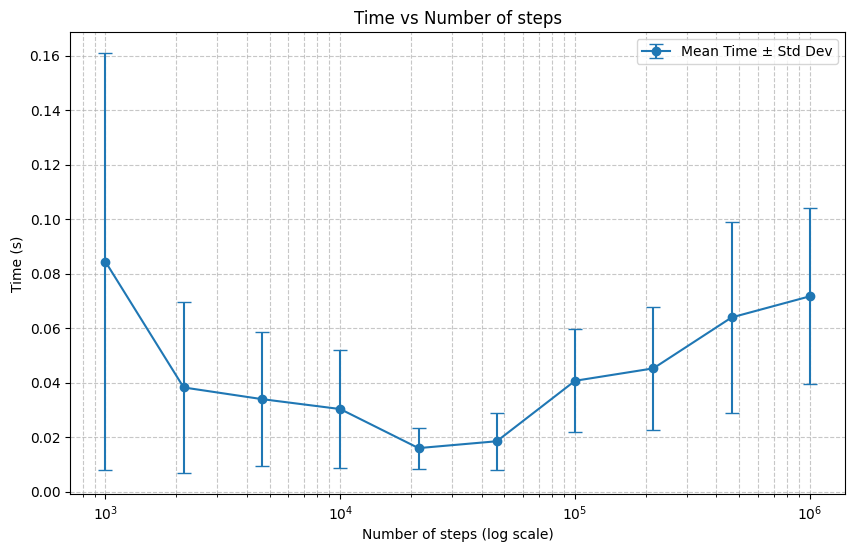

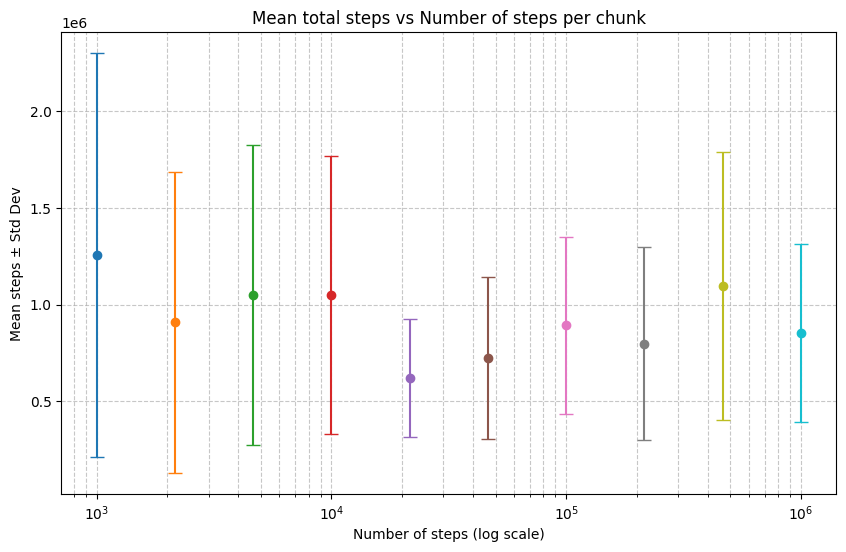

In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_runs = 20
n_it_per_chunk = np.logspace(3, 6, num=10, dtype=int)  # different n_it_per to test
p = [0, 0.25, 0.25, 0.25, 0.25] 
boundary = 10_000
multiply_factor = 10
start_point = (1000, 1000)

timing_results = {}


for n_it in n_it_per_chunk:
    times = []
    steps = []
    
    for _ in range(n_runs):
        t0 = time.perf_counter()
        result = simulate_path(
            start_point=start_point,
            p=p,
            n_it_per=n_it,
            boundary=boundary,
            trajectory=False,
            multiply_factor=multiply_factor
        )
        t1 = time.perf_counter()
        times.append(t1 - t0)
        steps.append(result["steps"])
    timing_results[n_it] = {
        "time_mean_s": np.mean(times),
        "time_std_s": np.std(times),
        "steps_mean": np.mean(steps),
        "steps_std": np.std(steps)
    }

def plot_times_vs_steps(timing_results):
    n_steps = list(timing_results.keys())
    times = [timing_results[n]['time_mean_s'] for n in n_steps]
    time_stds = [timing_results[n]['time_std_s'] for n in n_steps]

    plt.figure(figsize=(10, 6))
    plt.errorbar(n_steps, times, yerr=time_stds, fmt='o-', capsize=5, label='Mean Time ± Std Dev')
    plt.xscale('log')
    plt.xlabel("Number of steps (log scale)")
    plt.ylabel("Time (s)")
    plt.title("Time vs Number of steps")
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
def plot_steps_vs_nit(timing_results):
    plt.figure(figsize=(10, 6))
    for n_it, stats in timing_results.items():
        plt.errorbar(
            [n_it], [stats['steps_mean']],
            yerr=[stats['steps_std']],
            fmt='o', capsize=5
        )
    
    plt.xscale('log')
    plt.xlabel("Number of steps (log scale)")
    plt.ylabel("Mean steps ± Std Dev")
    plt.title("Mean total steps vs Number of steps per chunk")
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.show()

# Find the n_it with the lowest mean time
best_n_it = min(timing_results, key=lambda k: timing_results[k]["time_mean_s"])

# Get the corresponding values
lowest_mean_time = timing_results[best_n_it]["time_mean_s"]
corresponding_steps_mean = timing_results[best_n_it]["steps_mean"]


print(f"Best n_it: {best_n_it}")
print(f"Lowest mean time per run: {lowest_mean_time:.4f} s. Gives time per step per run: {lowest_mean_time/corresponding_steps_mean*1e6:.6f} microseconds.")
plot_times_vs_steps(timing_results)
plot_steps_vs_nit(timing_results)

We can see from the graphs that the distributions are heavily affected by a high variance. We will see this later in the problem, but now we see that the choice of chunk size is giving the lowest computation times at around 10000-50000 steps per run.  
From the plot, we can see that the time per step per run has decreased compared to previous methods, even though the average number of steps per run is much higher. This improvement is likely because we reduced the number of Python-level for loops, which are computationally expensive, and instead used more efficient operations. When the number of steps is very large and the number of walkers (runners) is relatively small, it can be more efficient to generate random numbers in bulk along each path rather than across all walkers—if we need to choose one approach. This minimizes loop overhead and leverages vectorized operations.  
Alternatively, we could design a solution that generates large chunks of random numbers both along and across walkers for maximum speed. However, because the total number of iterations is extremely high, this approach would require a huge amount of RAM and could lead to memory issues.  
We now continue with creating paths for $150 000$ steps over $500$ runs, to simulate the spatial distribution and the concentration map. We are using all the path positions to create the concentration map, and not just the end points.  
The recordings we obtain will be the trajectory, which is the positions each individual run has had through the run. And we will obtain the final positions, which is the simulated position in 10 meters that the contaminants have after $150 000$ years (number of steps).  
The plots illustrate the simulated contaminant density across all years (how many visits each positions has had) and display the final positions of the contaminants at the end of the simulation.

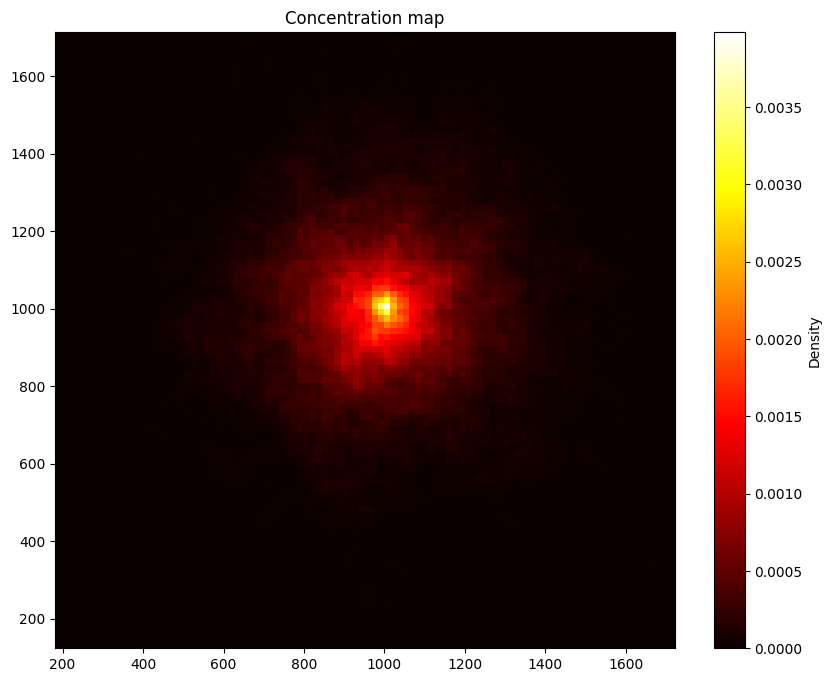

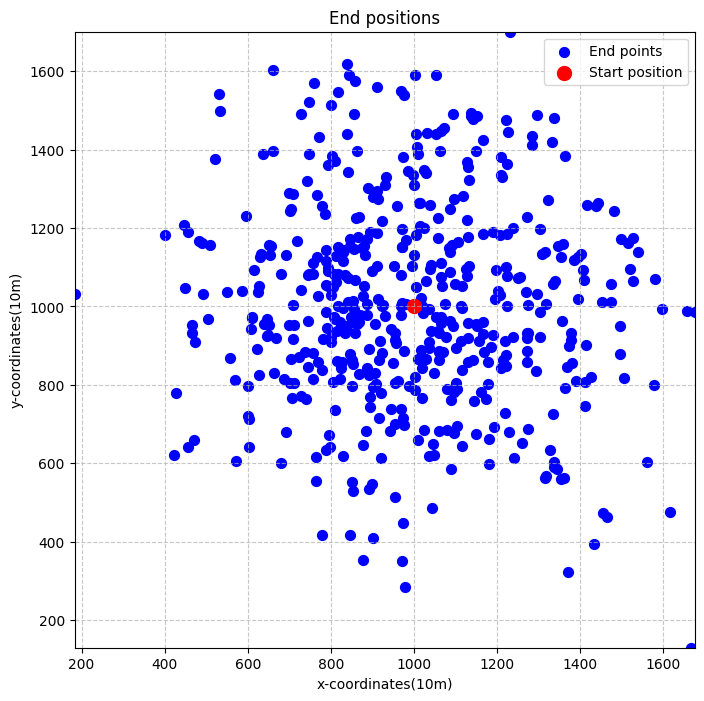

In [74]:
import matplotlib.pyplot as plt

n_runs=500
positions = []
end_positions = []
for _ in range(n_runs):
    
    dict = simulate_path_vec(
            start_point=(1000,1000),
            p=[0, 0.25, 0.25, 0.25, 0.25],
            n_steps=150_000,
            distance_boundary=False,
            trajectory=True,
            multiply_factor=10
        )
    
    positions.append(dict["trajectory"])
    end_positions.append(dict["final_position"])
    
positions = np.vstack(positions)
end_positions = np.vstack(end_positions)

x = positions[:, 0]
y = positions[:, 1]

# Compute histogram
def create_heatmap(x,y):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=(100, 100))
    heatmap = heatmap/heatmap.sum()
    plt.figure(figsize=(10, 8))
    plt.imshow(
        heatmap.T,
        origin='lower',
        cmap='hot',
        aspect='auto',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]  
    )
    plt.colorbar(label='Density')
    plt.title("Concentration map")
    plt.show()
create_heatmap(x,y)

xlim_ep=min(end_positions[:,0]), max(end_positions[:,0])
ylim_ep=min(end_positions[:,1]),max(end_positions[:,1])
plot_positions_matplotlib(end_positions, title="End positions", xlim=xlim_ep, ylim=ylim_ep, boundary=False,                          
                          x_label="x-coordinates(10m)", 
                          y_label="y-coordinates(10m)",)


From the plots we can see the concentration is decreasing gradually over the distance from the starting position. The end positions also show an even spread out from the start point, with less density the longer away from the start that we walk. 
***
***Solution 2.4:*** 


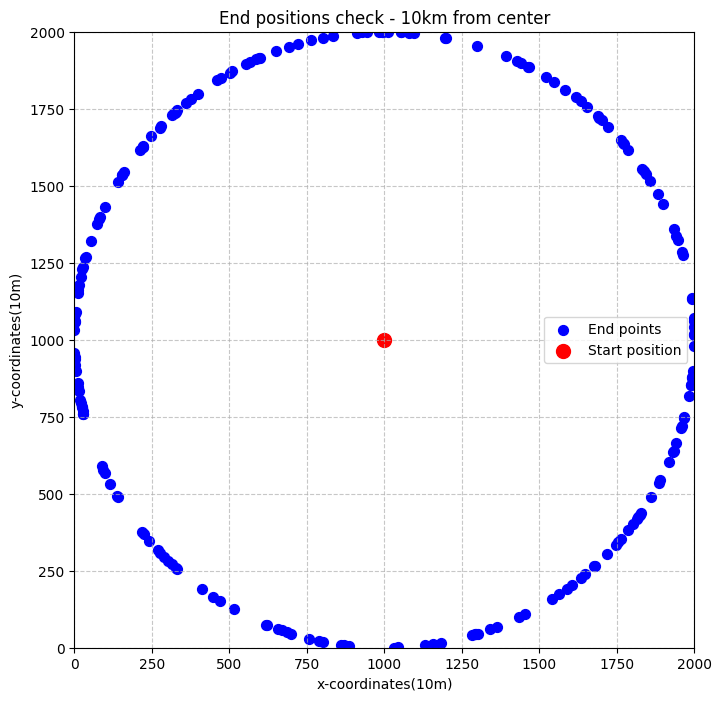

In [68]:
n_runs=200
arrival_steps = []
end_positions_unbiased = []
for _ in range(n_runs):
    
    dict = simulate_path(
            start_point=(1000,1000),
            p=[0, 0.25, 0.25, 0.25, 0.25],
            n_it_per=25000,
            boundary=10_000,
            trajectory=False,
            multiply_factor=10
        )
    end_positions_unbiased.append(dict["final_position"])
    arrival_steps.append(dict["steps"])
    
    

end_positions_unbiased = np.vstack(end_positions_unbiased)
plot_positions_matplotlib(end_positions_unbiased, 
                          title="End positions check - 10km from center", 
                          x_label="x-coordinates(10m)", 
                          y_label="y-coordinates(10m)",
                          boundary=False)

Here we check and see that the end distribution is around $r_{grid}=1000$, grid coordinates away from the center. This is the same as $r=1000\cdot 10m=10km$

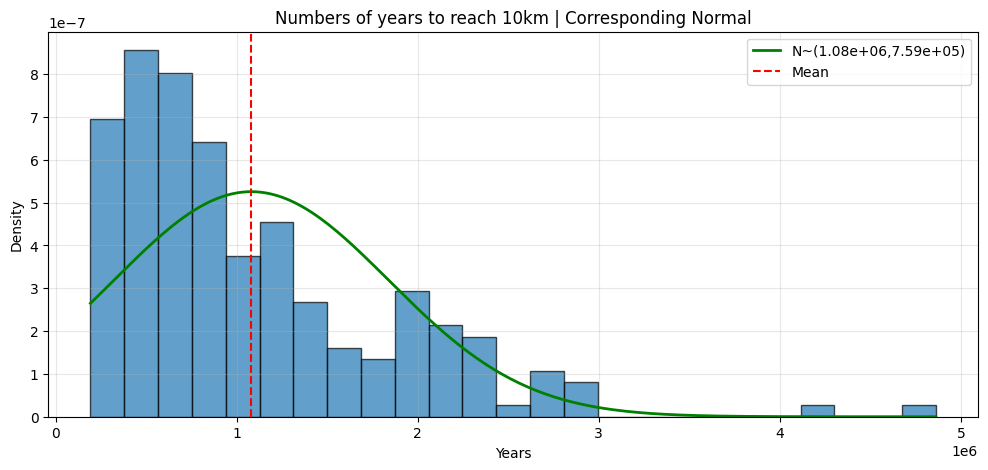

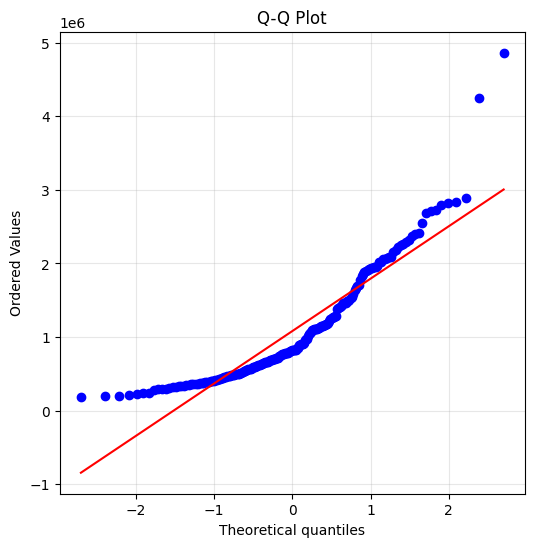

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, probplot #For deciding if the distribution can be approximated to a normal distribution.



def plot_hist_and_check_normality(k, title="Histogram"):
    
    mu = np.mean(k)
    sigma = np.std(k)
    x = np.linspace(min(k), max(k), 200)
    pdf = norm.pdf(x, mu, sigma)


    plt.figure(figsize=(12,5))
    plt.plot(x, pdf, color='green', linewidth=2, label=f"N~({mu:.2e},{sigma:.2e})")
    plt.hist(k, bins=25, color='C0', edgecolor='k', alpha=0.7, density=True)
    plt.axvline(np.mean(k), color='red', linestyle='--', label=f"Mean")
    plt.xlabel("Years")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def qq_plot(k, title="Q-Q Plot"):
    plt.figure(figsize=(6,6))
    probplot(k, dist="norm", plot=plt)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

    

plot_hist_and_check_normality(arrival_steps, "Numbers of years to reach 10km | Corresponding Normal")
qq_plot(arrival_steps)


From the histogram
10 km south means reaching the x-axis, i.e. y=0.

In [71]:
n_runs=1000
arrival_steps_mod = []
y_vals = []

for _ in range(n_runs):
    
    dict = simulate_path(
            start_point=(1000,1000),
            p=[0, 0.25, 0.25, 0.5/3, 0.5*2/3],
            n_it_per=25000,
            distance_boundary=False,
            fixed_boundary=True,
            lower_bound=(-50000,0), #To not hit lower x-boundary
            upper_bound=(50000,50000), #To not hit upper boundary
            trajectory=False,
            multiply_factor=10
        )
    
    y_vals.append(dict["final_position"][1])
    arrival_steps_mod.append(dict["steps"])
    
    
y_vals = np.array(y_vals)
print(f"Are all y-values final position equal to 0? {np.all(y_vals == 0)}")

Are all y-values final position equal to 0? True


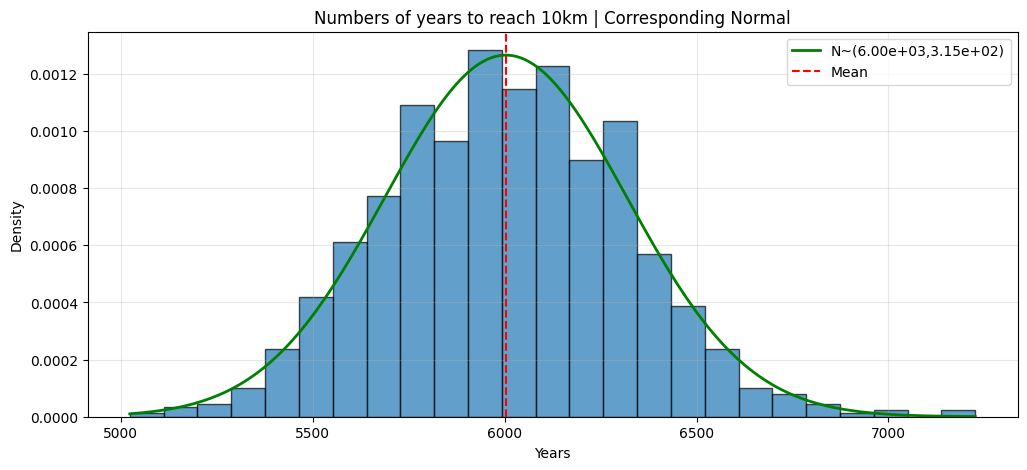

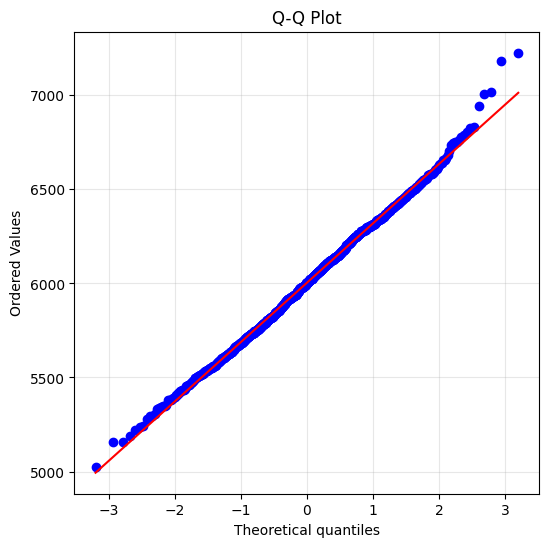

In [72]:
plot_hist_and_check_normality(arrival_steps_mod, "Numbers of years to reach 10km | Corresponding Normal")
qq_plot(arrival_steps_mod)